In [0]:
!pip install torchbearer

     |████████████████████████████████| 143kB 2.9MB/s 


In [0]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models as models
import torch
import torch.nn.functional as F
import torchbearer
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchbearer import Trial
import pandas as pd

In [0]:
# transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform= transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
from torchvision.models import resnet34
model = resnet34()
model.fc = nn.Linear(512,10)

In [0]:
from torchbearer.callbacks import StepLR
from torchbearer.callbacks.decorators import on_end_epoch

# def reduce_rate(state):
#   print(optimiser.lear)
sch = StepLR(step_size=150, gamma=0.1)
sch

In [0]:
%%time
loss_function = nn.CrossEntropyLoss()
# optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
optimiser = optim.Adam(model.parameters(), lr=0.001,betas=(0.99, 0.999), weight_decay=5e-4)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial = Trial(model, optimiser, loss_function,callbacks=[sch], metrics=['loss', 'accuracy','lr']).to(device)
trial.with_generators(trainloader, val_generator=testloader)
history = trial.run(epochs=200)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git


CPU times: user 1h 14min 24s, sys: 2min 36s, total: 1h 17min 1s
Wall time: 1h 33min 51s


In [0]:
def get_data(history,name):
  train_acc = [x['acc'] for x in history]
  train_loss = [x['loss'] for x in history]
  test_acc = [x['val_acc'] for x in history]
  test_loss = [x['val_loss'] for x in history]
  frame = pd.DataFrame(zip(train_acc,train_loss,test_acc,test_loss))
  frame.columns = ['train_acc','train_loss','val_acc','val_loss']
  frame.to_csv(name)
  return frame

In [0]:
frame = get_data(history,'Adam_ResNet.csv')

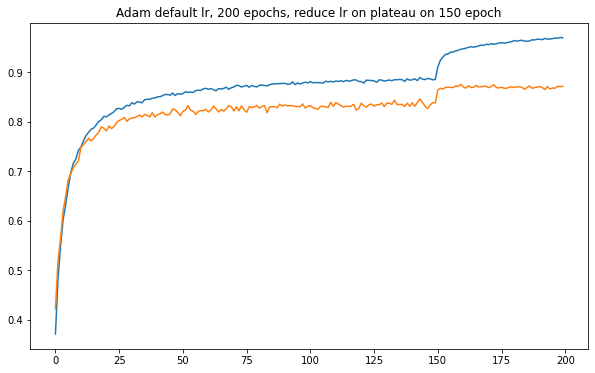

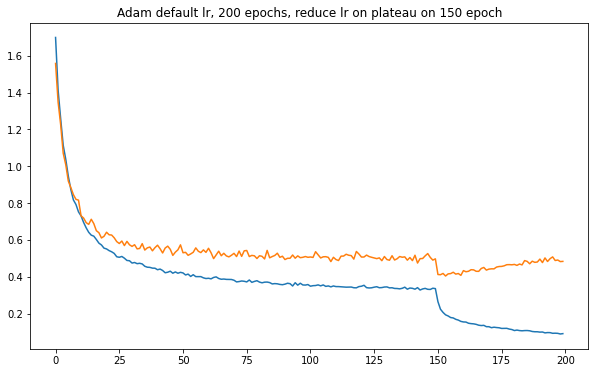

In [0]:
plt.figure(figsize=(10,6))
plt.title('Adam default lr, 200 epochs, reduce lr on plateau on 150 epoch')
plt.plot(range(200),frame['train_acc'])
plt.plot(range(200),frame['val_acc'])

plt.figure(figsize=(10,6))
plt.title('Adam default lr, 200 epochs, reduce lr on plateau on 150 epoch')
plt.plot(range(200),frame['train_loss'])
plt.plot(range(200),frame['val_loss'])